## Principal Component Analysis

Principal Component Analysis or PCA is a tool used to compress the dimensionality of a data set. It is particularly useful for building small compact emulators. The idea is to find the eigenvectors along which the data set varies the most, through away all but those n axis and train the emulator to predict coefficients on these axis. In the example I show how to find the most informative eigenvectors for a set of 15000 gaussian 21-cm like signals. I then show how to find the most useful axis and how to reconstruct signals from the basis coefficients.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tqdm import tqdm
import time

### Training data

First we need to generate some training data. In this case it is just a set of Gaussian absorption features designed to mimic the sky-averaged 21-cm signal as a function of redshfit.

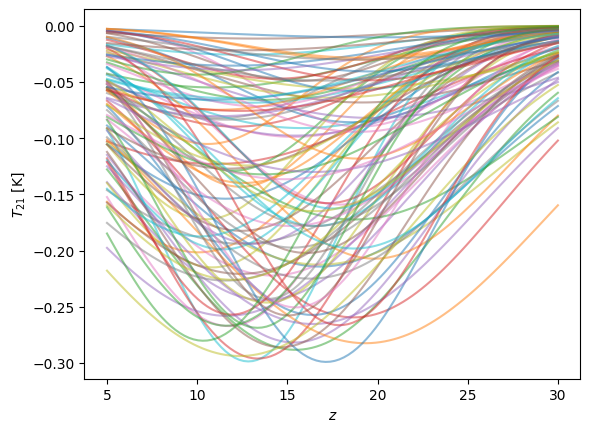

In [2]:
def gaussian(parameters):
    """a simple Gaussian function"""
    return -parameters[0] * \
        np.exp(-0.5*(z - parameters[1])**2/
               parameters[2]**2)

def prior(n):
    """a simple prior"""
    theta = np.ones((n, 3))
    theta[:, 0] = np.random.uniform(0.01, 0.3, n) # amplitude
    theta[:, 1] = np.random.uniform(10, 20, n) # mean
    theta[:, 2] = np.random.uniform(5, 10, n) # width
    return theta

z = np.linspace(5, 30, 100)[::-1]
n = 15000
parameters = prior(n)
signals = np.array([gaussian(parameters[i]) for i in range(n)])
sample = np.random.randint(0, n, 100)
[plt.plot(z, signals[i], alpha=0.5) for i in range(len(sample))]
plt.xlabel(r'$z$')
plt.ylabel(r'$T_{21}$ [K]')
plt.savefig('gaussian-signals.png', dpi=300, bbox_inches='tight')

### Normalisation

PCA performs better if we normalise our signals. Here I am subtracting the mean from the training data and dividing them by the standard deviation of the training data. This process is also known as standardisation.

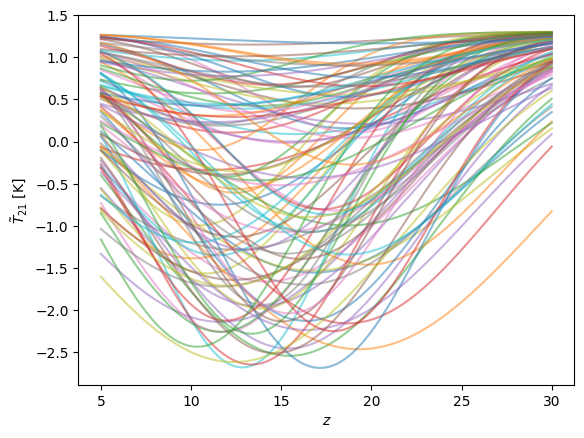

In [3]:
norm_signals = (signals - signals.mean())/signals.std()

[plt.plot(z, norm_signals[i], alpha=0.5) for i in range(len(sample))]
plt.xlabel(r'$z$')
plt.ylabel(r'$\tilde{T}_{21}$ [K]')
plt.savefig('gaussian-signals.png', dpi=300, bbox_inches='tight')

### PCA decomposition

We first want to take the covariance of our normalised signals and then find their eigenvectors and eigenvalues. The eigenvector represents a direction of variance and the eigenvector with the largest eigenvalue represents the direction with the biggest variance.

In [4]:
cov = np.cov(norm_signals, rowvar=False)
eig_vals, eig_vecs = np.linalg.eig(cov)

### Sort the eigenvectors

We need to sort the eigenvalues and vectors based on the eigenvalues and find the set of vectors that give us the most information about how the signal varies.

[0.77354716 0.96959968 0.99648558 0.99972522 0.99998067 0.99999879
 0.99999994 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


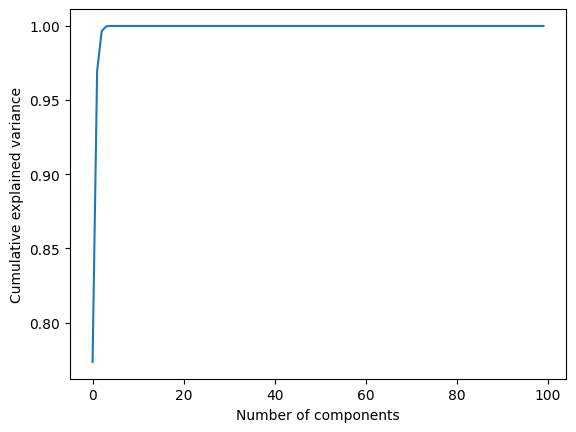

In [5]:
args = np.argsort(eig_vals)[::-1]
eig_vals = np.real(eig_vals[args])
eig_vecs = eig_vecs[:, args]

sum_eig_vals = np.sum(eig_vals)

explained_vairance = eig_vals/sum_eig_vals
cumulative_explained_variance = np.cumsum(explained_vairance)

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.savefig('cumulative-explained-variance.png', dpi=300, bbox_inches='tight')

print(cumulative_explained_variance)

From the graph and the printed cumulative explained vairance it looks like 8 components is sufficient. To get the coefficients for the training data we have to take the dot product of the normalised signals with the eigenvectors corresponding to the first 8 eigenvalues. To reconstruct a signal we multiply its coefficients by the vectors, sum the result and unnormalize.

One can imagine training a neural network to translate between the amplitude, width and central redshift of the Gaussian and coeffients on the principle 8 eigenvectors describing the training data. Instead of predicting a hundred values of temperature, one at each redshift data point, one only needs to predict 8 parameters. The dimensionality of the problem is dramatically reduced and the network will be significantly easier to train. However information about the signal can be loss in a PCA decomposition.

/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


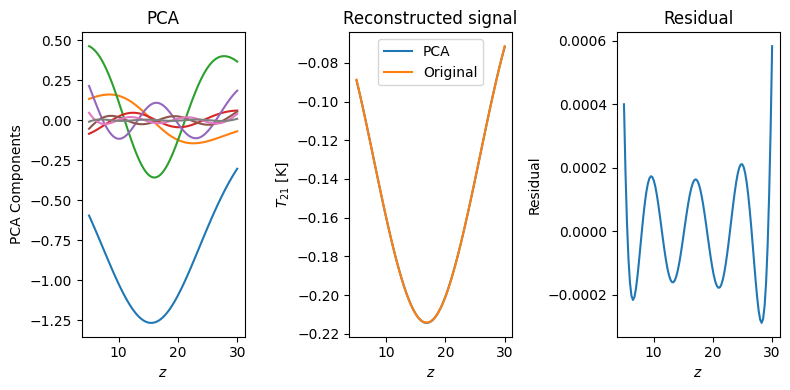

In [16]:
ncomponents = 8

pca_data = np.dot(norm_signals, eig_vecs[:, :ncomponents])

s = pca_data[0]*eig_vecs[:, :ncomponents]
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
axes[0].plot(z, s)
s = np.sum(s, axis=1)
s = s*signals.std() + signals.mean()
axes[1].plot(z, s, label='PCA')
axes[1].plot(z, signals[0], label='Original')
axes[2].plot(z, signals[0] - s)
for i in range(3):
    axes[i].set_xlabel(r'$z$')
axes[0].set_ylabel('PCA Components')
axes[1].set_ylabel(r'$T_{21}$ [K]')
axes[0].set_title('PCA')
axes[1].set_title('Reconstructed signal')
axes[2].set_title('Residual')
axes[2].set_ylabel('Residual [K]')
axes[1].legend()
plt.tight_layout()
plt.savefig('reconstructed-signal.png', dpi=300, bbox_inches='tight')

